In [1]:
import keras
from keras.layers import Dense,Conv2D,MaxPool2D,Activation, Dropout, Flatten, Dense,BatchNormalization,Input ,LeakyReLU ,Reshape,Conv2DTranspose
from keras.models import Model,Sequential
from keras.optimizers import RMSprop
import numpy as np
import pandas as pandas
from keras.datasets import cifar10
import os

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(X_train, y_train), (_,_) = cifar10.load_data()

170500096/170498071 [==============================] - 29s 0us/step


In [3]:
print(X_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 1)


In [4]:
gen_input=Input(shape=(32,)) #random
x = Dense(16*16*128)(gen_input) #Generator starts with Dense due to its random dimension input
x = LeakyReLU()(x) 
x = Reshape((16,16,128))(x) 
x = Conv2D(256,5,padding="same")(x) #padding *
x = LeakyReLU()(x)
x = Conv2DTranspose(256, 4, strides=2, padding='same')(x) #upsampling to 32*32*3
x = LeakyReLU()(x)
x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(3,7, activation='tanh', padding='same')(x) #test value of 3 #tanh*
generator=Model(gen_input,x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

In [5]:
discr_input=Input(shape=(32,32,3)) #input that 32*32*3 to output fake/real=1
x = Conv2D(128,3)(discr_input)
x = LeakyReLU()(x)
x = Conv2D(128, 4,strides=2)(x) #strides*
x = LeakyReLU()(x)
x = Conv2D(128, 4,strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(128, 4,strides=2)(x)
x = LeakyReLU()(x)
x = Flatten()(x)
# One dropout layer - important trick!
x = Dropout(0.4)(x)
x = Dense(1,activation='sigmoid')(x)

discriminator=Model(discr_input, x)
discriminator.summary()
rmsprop=RMSprop(lr=0.0005,clipvalue=1.0,decay=1e-8) #gradient clipping
discriminator.compile(optimizer=rmsprop,loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)         0         
__________

In [6]:
discriminator.trainable = False # otherwise everytime it will predict real

gan=Sequential()
gan.add(generator)
gan.add(discriminator)
rmsprop=RMSprop(lr=0.0004,clipvalue=1.0,decay=1e-8)
gan.compile(optimizer=rmsprop, loss='binary_crossentropy')

In [7]:
X_train = X_train[y_train.flatten() == 6] # referring to one class in cifar10
print(X_train.shape)
#normalize
X_train = X_train.reshape((X_train.shape[0],) + (32,32,3)).astype('float32') / 255.

(5000, 32, 32, 3)


In [8]:
iterations = 10000
batch_size = 20

start = 0
for step in range(iterations):
    noise = np.random.normal(size=(batch_size,32)) # generate noise
    generated_images = generator.predict(noise) #predictions on noise
    stop = start + batch_size
    real_images = X_train[start: stop] #from cifar 10
    combined_images = np.concatenate([generated_images, real_images]) #sumup
    labels=np.concatenate([np.ones((batch_size, 1)),np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape) #noise****
    discr=discriminator.train_on_batch(combined_images, labels) #train d

    noise1 = np.random.normal(size=(batch_size,32))
    targets=np.zeros((batch_size, 1))
    my_gan=gan.train_on_batch(noise1,targets)
    
    start += batch_size
    if start > len(X_train) - batch_size:
        start = 0

    if step % 200 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step,discr))
        print('adversarial loss at step %s: %s' % (step,my_gan))

/opt/conda/lib/python3.6/site-packages/Keras-2.1.5-py3.6.egg/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


discriminator loss at step 0: 0.6818717
adversarial loss at step 0: 0.68783414
discriminator loss at step 200: 0.72305197
adversarial loss at step 200: 0.76223844
discriminator loss at step 400: 0.69259745
adversarial loss at step 400: 0.72259283
discriminator loss at step 600: 0.69325125
adversarial loss at step 600: 0.7606524
discriminator loss at step 800: 0.68691164
adversarial loss at step 800: 0.7473835
discriminator loss at step 1000: 0.6910365
adversarial loss at step 1000: 0.7361349
discriminator loss at step 1200: 0.68973666
adversarial loss at step 1200: 0.74564487
discriminator loss at step 1400: 0.70378447
adversarial loss at step 1400: 0.7428377
discriminator loss at step 1600: 0.69416076
adversarial loss at step 1600: 0.74732244
discriminator loss at step 1800: 0.67857236
adversarial loss at step 1800: 0.7788509
discriminator loss at step 2000: 0.6913767
adversarial loss at step 2000: 0.7475215
discriminator loss at step 2200: 0.69352305
adversarial loss at step 2200: 0.

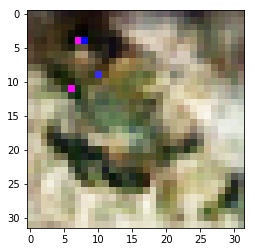

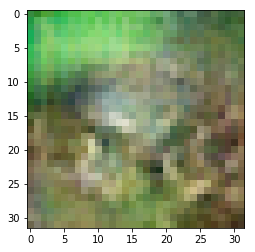

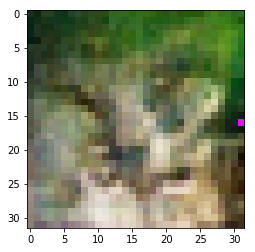

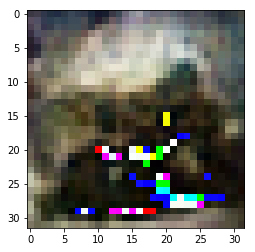

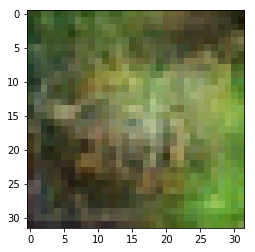

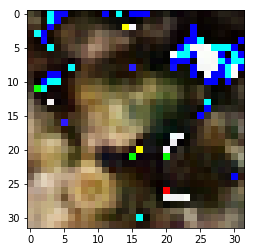

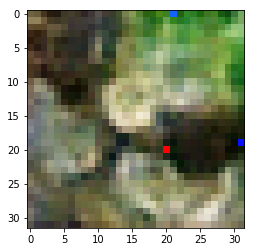

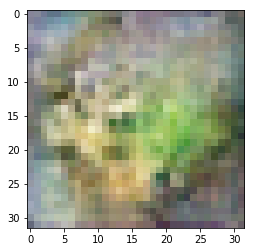

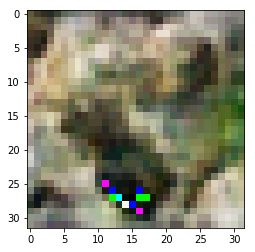

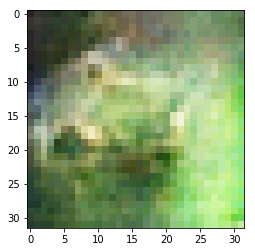

In [10]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
# Sample random points in the latent space
latent_dim=32
random_latent_vectors = np.random.normal(size=(10, latent_dim))
# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()